In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

# Check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [2]:
# Load ETTh1 dataset
df = pd.read_csv('/kaggle/input/ett-dataset/ETTh1.csv')  # Adjust the path if different
print(df.head())

# Example: 'date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'
# We'll predict 'OT' (Oil Temperature)


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [3]:
# Select relevant columns
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']  # All features
target_col = ['OT']  # Target is 'OT'

# Normalize features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

data = df[feature_cols].values  # shape (N, features)
print('Data shape:', data.shape)


Data shape: (17420, 7)


In [4]:
# Parameters
input_window = 96
output_window = 24

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_window, output_window):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.input_window = input_window
        self.output_window = output_window

    def __len__(self):
        return len(self.data) - self.input_window - self.output_window

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_window]     # (input_window, features)
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window, -1:]  # only target OT
        return x, y

dataset = TimeSeriesDataset(data, input_window, output_window)

# Split into train/val/test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')


Train samples: 12110, Val samples: 3460, Test samples: 1730


In [5]:
class RealisticMambaLayer(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.expand = expand
        self.d_inner = expand * d_model

        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            kernel_size=d_conv,
            groups=self.d_inner,
            padding=d_conv - 1,
            bias=True
        )
        self.A_log = nn.Parameter(torch.randn(self.d_inner, d_state) * 0.02)
        self.D = nn.Parameter(torch.ones(self.d_inner))
        self.x_proj = nn.Linear(self.d_inner, 2 * self.d_inner * self.d_state + self.d_inner, bias=False)
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)

    def forward(self, u):
        B, T, _ = u.shape
        u_proj = self.in_proj(u)
        u_proj, gate = u_proj.chunk(2, dim=-1)
        u_proj = u_proj * torch.sigmoid(gate)

        u_proj = u_proj.transpose(1, 2)
        u_proj = self.conv1d(u_proj)[..., :T]
        u_proj = u_proj.transpose(1, 2)

        x_proj = self.x_proj(u_proj)
        B_u, C_u, dt_u = torch.split(
            x_proj, [self.d_inner * self.d_state, self.d_inner * self.d_state, self.d_inner], dim=-1
        )
        B_u = B_u.view(B, T, self.d_inner, self.d_state)
        C_u = C_u.view(B, T, self.d_inner, self.d_state)
        dt = F.softplus(dt_u)

        A = -torch.exp(self.A_log)
        x = torch.zeros(B, self.d_inner, self.d_state, device=u.device)

        y_out = []
        for t in range(T):
            x = torch.exp(dt[:, t].unsqueeze(-1) * A) * x + B_u[:, t]
            y_t = torch.sum(x * C_u[:, t], dim=-1) + self.D * u_proj[:, t]
            y_out.append(y_t)

        y_out = torch.stack(y_out, dim=1)
        y = self.out_proj(y_out)
        return y

class RealisticMambaModel(nn.Module):
    def __init__(self, d_model, d_input, d_output, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.input_proj = nn.Linear(d_input, d_model)
        self.mamba = RealisticMambaLayer(d_model, d_state, d_conv, expand)
        self.output_proj = nn.Linear(d_model, d_output)

    def forward(self, x):
        h = self.input_proj(x)
        h = self.mamba(h)
        y_pred = self.output_proj(h)
        return y_pred


In [6]:
# Model hyperparameters
d_model = 64  # size of hidden layer

model = RealisticMambaModel(d_model=d_model, d_input=len(feature_cols), d_output=1).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [7]:
# Training
epochs = 10

for epoch in range(epochs):
    model.train()
    train_losses = []

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)  # (batch, input_window, features)
        y_batch = y_batch.to(device)  # (batch, output_window, 1)

        optimizer.zero_grad()
        output = model(x_batch)  # (batch, input_window, 1)
        output = output[:, -output_window:]  # take last output_window steps
        
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    val_losses = []
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            output = model(x_val)
            output = output[:, -output_window:]
            val_loss = loss_fn(output, y_val)
            val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {np.mean(train_losses):.6f}, Val Loss: {np.mean(val_losses):.6f}")


Epoch 1/10, Train Loss: 0.009477, Val Loss: 0.003303
Epoch 2/10, Train Loss: 0.003726, Val Loss: 0.003643
Epoch 3/10, Train Loss: 0.003567, Val Loss: 0.003501
Epoch 4/10, Train Loss: 0.003589, Val Loss: 0.003286
Epoch 5/10, Train Loss: 0.003582, Val Loss: 0.003213
Epoch 6/10, Train Loss: 0.003422, Val Loss: 0.003818
Epoch 7/10, Train Loss: 0.003396, Val Loss: 0.003757
Epoch 8/10, Train Loss: 0.003404, Val Loss: 0.003495
Epoch 9/10, Train Loss: 0.003419, Val Loss: 0.003604
Epoch 10/10, Train Loss: 0.003362, Val Loss: 0.003340


In [8]:
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        output = model(x_test)
        output = output[:, -output_window:]

        test_preds.append(output.cpu())
        test_targets.append(y_test.cpu())

test_preds = torch.cat(test_preds, dim=0)
test_targets = torch.cat(test_targets, dim=0)

# Compute MAE
mae = torch.mean(torch.abs(test_preds - test_targets))
print(f"Test MAE: {mae.item():.6f}")


Test MAE: 0.044375


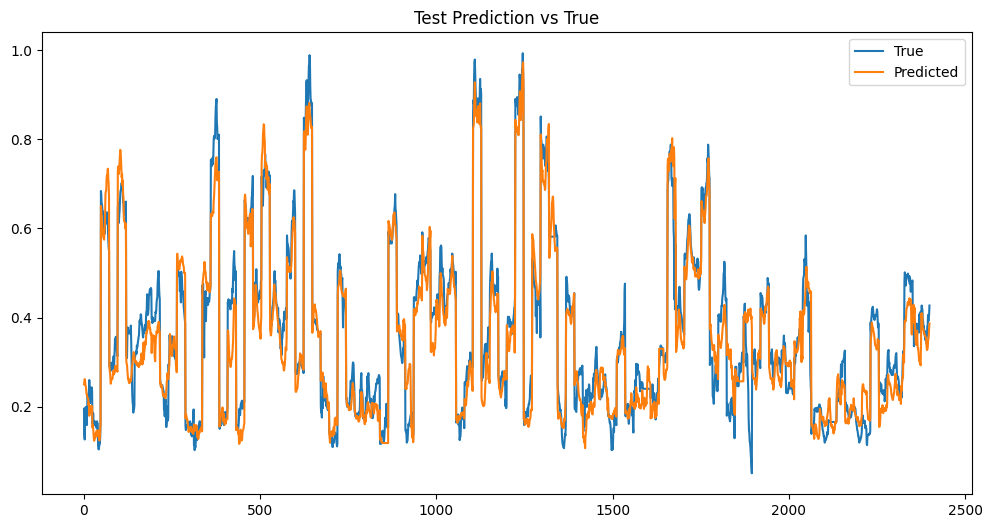

In [9]:
plt.figure(figsize=(12,6))
plt.plot(test_targets[:100].flatten(), label='True')
plt.plot(test_preds[:100].flatten(), label='Predicted')
plt.legend()
plt.title('Test Prediction vs True')
plt.show()
